# Week Five - Part 2 - Assignment: Document Classification
#### Team Members: Stefano Biguzzi, Ian Costello, Dennis Pong  
It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  UCI Machine Learning Repository: Spambase Data Set

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

_This assignment is due end of day on Sunday._

__NOTE: This is a two week assignment.__

## Import Libraries
First we import the libraries we are going to use for the following assignment, since we are using a Naive Bayes algorithm, we import `MultinomialNB` from `sklearn.naive_bayes`. We also had to load additional libraries to create the compiled `bbc_news_docs.txt` file that was uploaded to github for reproducibility.

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import warnings
import nltk
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')

sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1.5)

## Create compiled file
we initiate a final dataframe and list out all the folder names for eachnew section. We then loop through each folder name take all the .txt files that appear in the folder and load them into an initial dataframe where we rename a column, create the class column, and join the rows of that file into one row. Finally we append the initial dataframe, which is one row per file, into the final dataframe to upload to github.

In [2]:
# txt_df = pd.DataFrame()
path_list = ['entertainment','politics','sport','tech','business']
# for p in path_list:
#     link = 'C:/Users/biguz/Desktop/CUNY Data Science/Summer2021/DATA 620/Assignments/Assignment 5/{}'.format(p)
#     os.chdir(link)
#     files = glob.glob('*.txt')
#     for f in files:
#         txt = pd.read_csv(f,sep='delimiter',header=None,error_bad_lines=False)
#         txt.rename(columns={0:'text'},inplace=True)
#         txt['class'] = p
#         txt['file'] = p+'_'+f
#         txt = txt.groupby(['class','file'])['text'].apply(' '.join).reset_index()
#         txt_df = txt_df.append(txt).reset_index(drop=True)

In [3]:
# os.chdir(r'C:/Users/biguz/Desktop/CUNY Data Science/Summer2021/DATA 620/Assignments/Assignment 5')
# txt_df.to_csv('bbc_news_docs.txt',sep='|',index=False)

## Load Data / Data Cleaning
We load the compiled data from github and save it as `txt_df`. The data consists of:
1. `class`: the topic of the document: entertainment, politics, sport, tech, or business
2. `file`: the original file of the text
3. `text`: the full text of the document

The dataframe is 2,225 rows long with 511 sport articles, 510 business articles, 417 politics articles, 401 tech articles, and 386 entertainment articles. tech had the longest articles with 502 words on average, while business had the lowest word count with 328 words on average.

In [4]:
url = 'https://raw.githubusercontent.com/sbiguzzi/data620/main/Assignments/bbc_news_docs.txt'
txt_df = pd.read_csv(url,sep='|')
txt_df['doc_len'] = txt_df['text'].apply(lambda x: len(x.split(' ')))
txt_df.sample(n=5).reset_index(drop=True)

,class,file,text,doc_len
0,politics,politics_203.txt,New foot and mouth action urged A senior Tory ...,422
1,sport,sport_416.txt,Italy 8-38 Wales Wales secured their first awa...,723
2,sport,sport_292.txt,Wales coach elated with win Mike Ruddock paid ...,230
3,sport,sport_438.txt,Davenport hits out at Wimbledon World number o...,248
4,sport,sport_454.txt,Hingis hints at playing comeback Martina Hingi...,145


In [5]:
txt_df.groupby('class')['file'].nunique().reset_index().sort_values('file',ascending=False).reset_index(drop=True)

,class,file
0,sport,511
1,business,510
2,politics,417
3,tech,401
4,entertainment,386


In [6]:
txt_df.groupby('class')['doc_len'].mean().astype(int).reset_index().sort_values('doc_len',ascending=False).reset_index(drop=True)

,class,doc_len
0,tech,502
1,politics,453
2,entertainment,330
3,sport,329
4,business,328


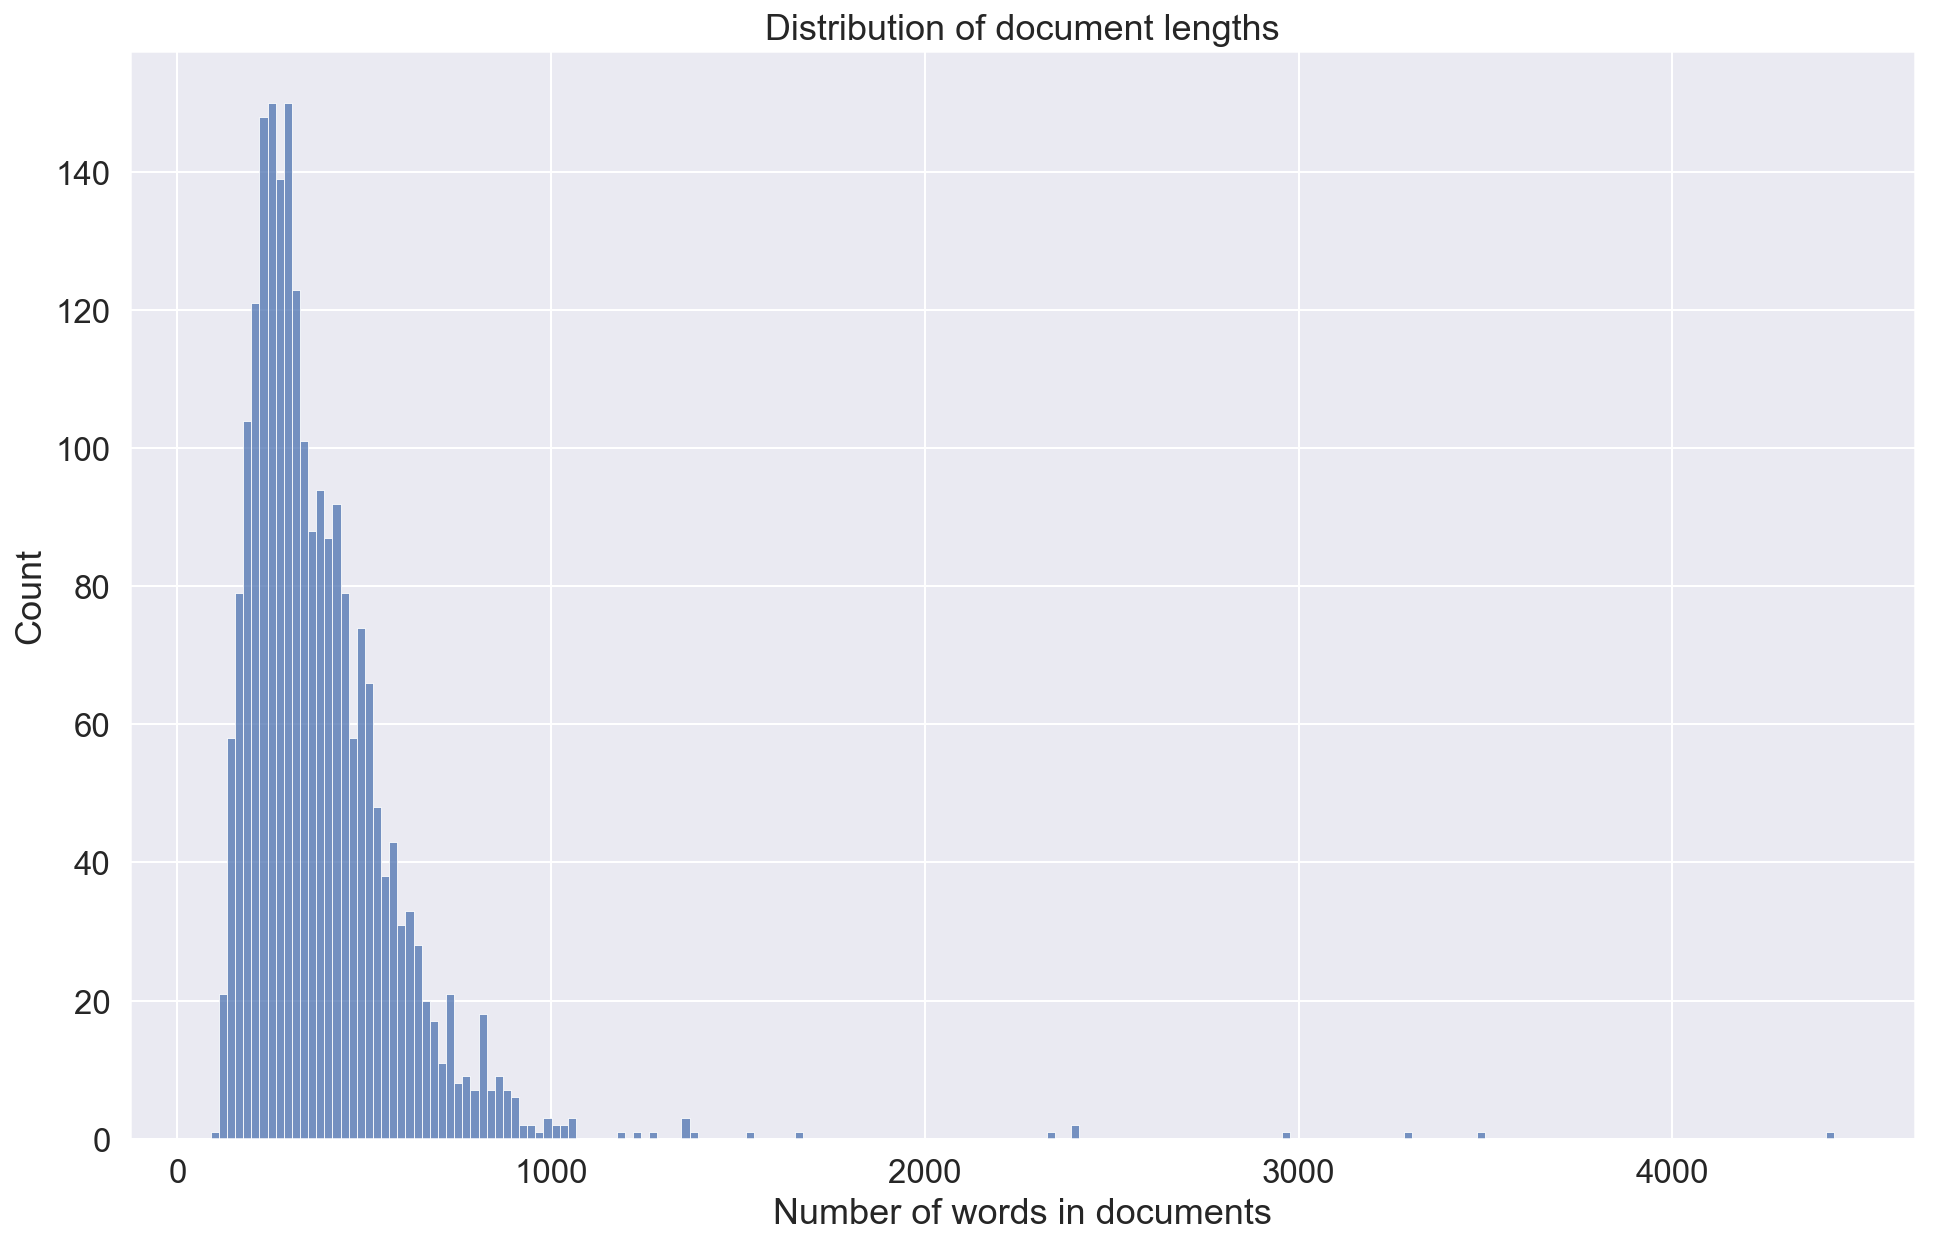

In [7]:
# plot document lengths
fig, ax = plt.subplots(figsize=(16,10))
sns.histplot(txt_df, x='doc_len', ax=ax, bins=200)
ax.set_xlabel('Number of words in documents')
ax.set_ylabel('Count')
ax.set_title('Distribution of document lengths')
plt.show()

Next we want to add a category label column. Since there are 5 document types, we create a label between 0 and 4. entertainment is 0, politics is 1, sport is 2, tech is 3, and business is 4. This way the bayes algorithm can categorize each document with the appropriate label.

In [8]:
label_dict = {}
for num,c in enumerate(path_list):
    label_dict.update({c:num})

In [9]:
txt_df['label'] = txt_df['class'].map(label_dict)
txt_df.sample(n=5)

,class,file,text,doc_len,label
1344,tech,tech_031.txt,Solutions to net security fears Fake bank e-ma...,891,3
1671,tech,tech_358.txt,What price for 'trusted PC security'? You can ...,1003,3
1529,tech,tech_216.txt,TV future in the hands of viewers With home th...,730,3
1833,business,business_119.txt,Bank opts to leave rates on hold The Bank of E...,456,4
2065,business,business_351.txt,Mild winter drives US oil down 6% US oil price...,211,4


## Document Classification
### Create train and test data
Next we create the train and test data by using `train_test_split` to split the txt_df data inot 75% train and 25% test data. We get 1668 rows of training data and 557 rows of test data.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(txt_df['text'], txt_df['label'], test_size=0.25, random_state=123)

In [11]:
print('X_train:',len(X_train),'\ny_train:',len(y_train),'\nX_test:',len(X_test),'\ny_test:',len(y_test))

X_train: 1668 
y_train: 1668 
X_test: 557 
y_test: 557


### Vectorize
For the algorithm to work, the data has to be set up where the classifier can identify each row as a document and each column as a word to calculate how many times a word appears in that document. To create this document-word matrix we need to use the `CountVectorizer()` function from the sklearn package. We instantiate the vectorizer, then we assignt the vectorizer to the X data for the training and testing data.

In [12]:
cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')

In [13]:
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

We can convert the vectorized data to a dataframe. In the example below we see that the word __milburn__ occurs in the document at index 2 one time.

In [14]:
word_freq_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())
word_freq_df.sample(n=15,axis='columns',random_state=2).head()

,cameron,unflappable,tacklers,exhorting,milburn,list,applying,olga,suitors,excerpt,neon,instantly,elusive,attached,cornered
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We can then summarize the above matrix by column to create the frequency of words in the full corpus. The distribution graph below indicates that most words are used very little, with an average frequency of 13 and a median frequency of 2.

In [15]:
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False).reset_index()
top_words_df.head()

,index,0
0,s,6848
1,said,5368
2,mr,2223
3,year,1760
4,people,1528


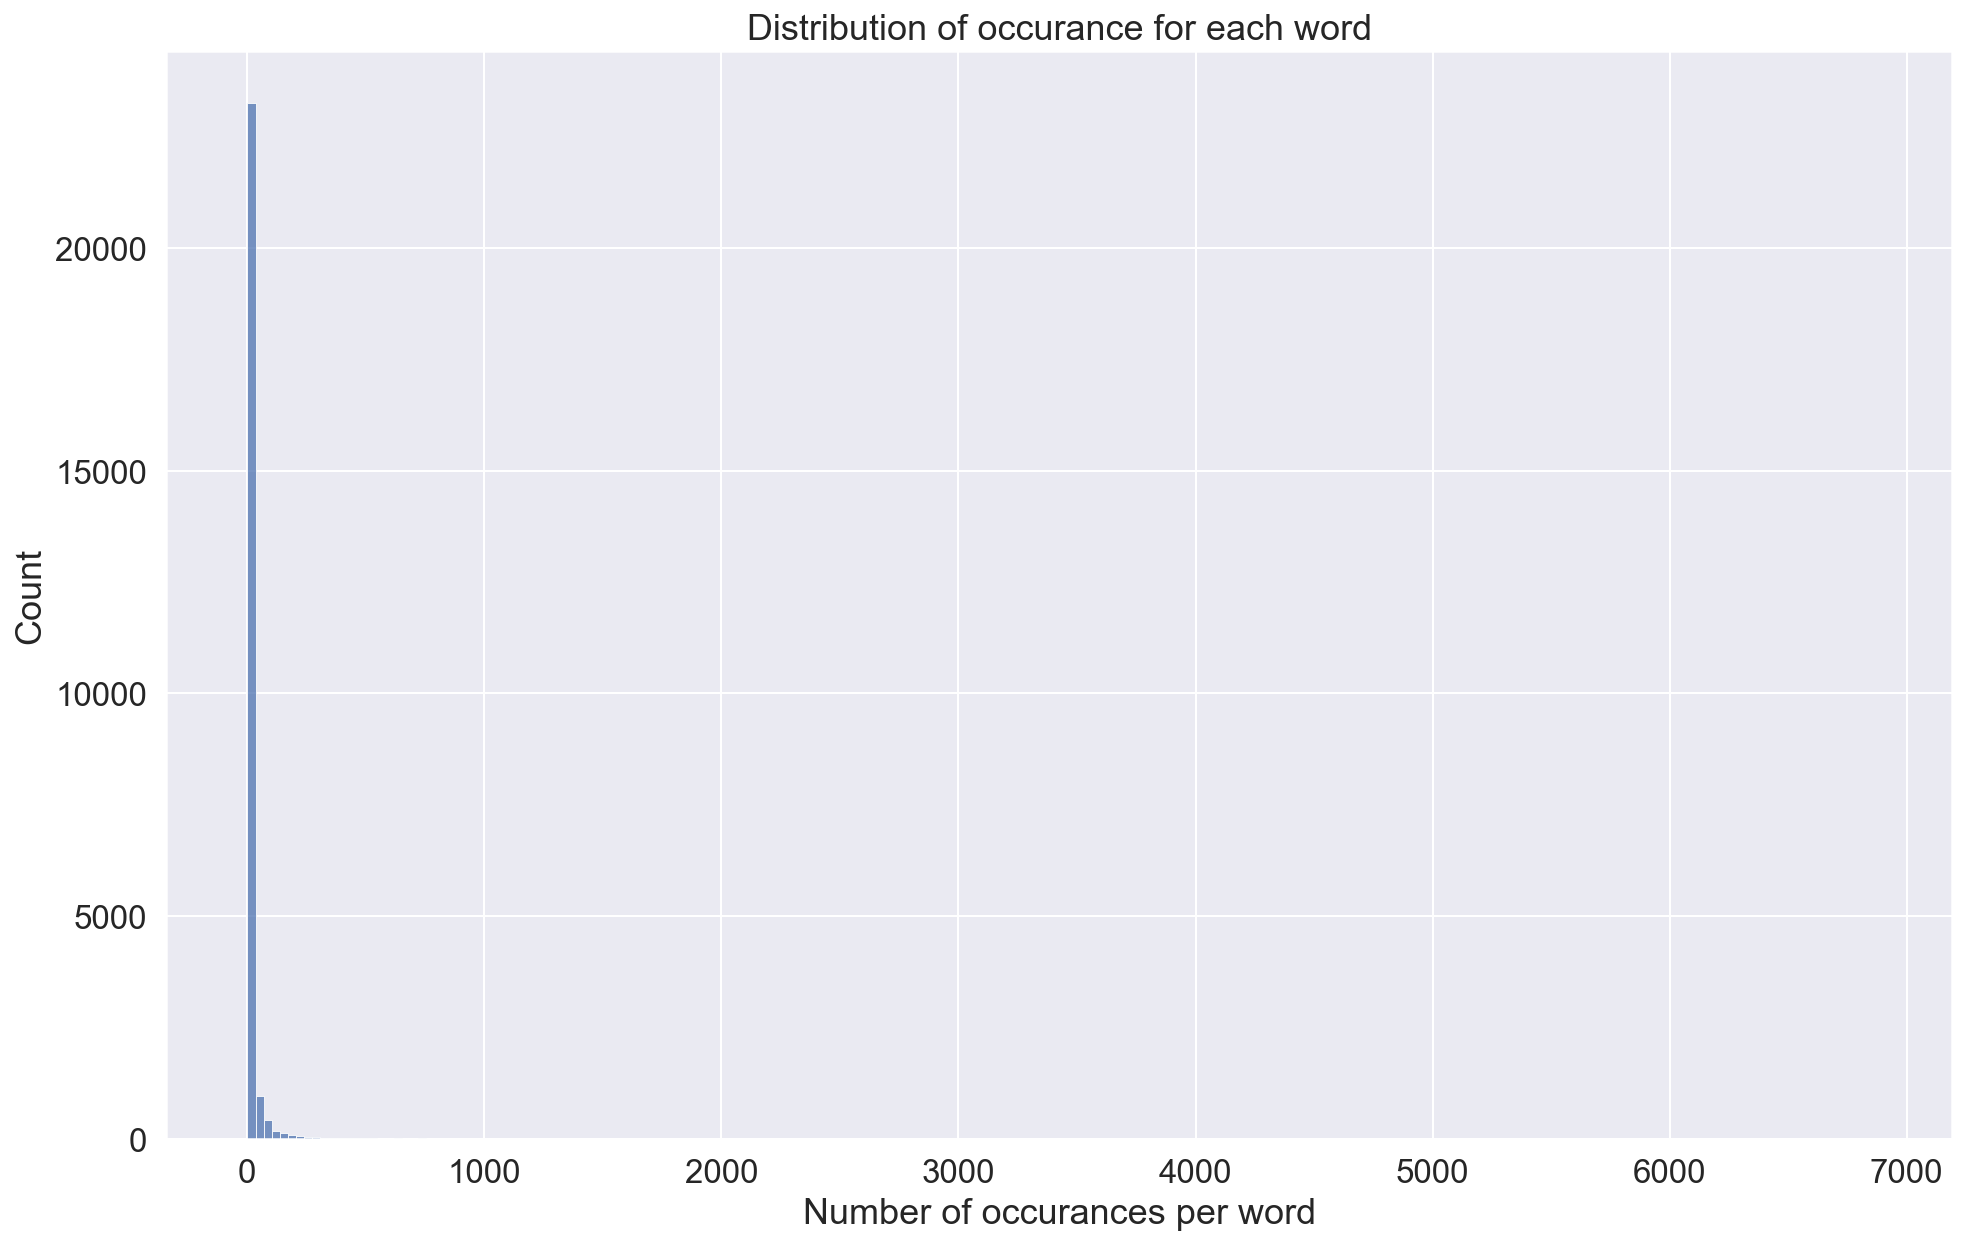

In [16]:
# plot word frequency
fig, ax = plt.subplots(figsize=(16,10))
sns.histplot(top_words_df, x=0, ax=ax, bins=200)
ax.set_xlabel('Number of occurances per word')
ax.set_ylabel('Count')
ax.set_title('Distribution of occurance for each word')
plt.show()

### Create Model and Predict
We initiate the naive_bayes model using the `MultinomialNB()` class and then we fit the train data. We make sure to use the vectorized x data, `X_train_cv`. We then set the predictions using the X test data, again make sure to use the vectorized data, `X_test_cv`.

In [17]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_cv, y_train)
predictions = naive_bayes.predict(X_test_cv)

### Conclusion
Below are the different preformance measurements. The accuracy score answers how many of the identifications made were correct, the precision score lets us now how many of the each category we got correct, and finally the recall score lets us know how many of the true cases of each category we predicted correctly. The heatmap below helps us understand the scores a little better.
* Accuracy score = diagonal sum from top left to bottom right / total observations = (79+111+137+110+111)/557 = 98.4%
* Precision score (tech) = true positive (tech)/(true positives + false positives) = 110/(110+2+1) = 97.3%
* Recall score (sport) = true positives (sport)/(true positives + false negatives) = 110/(110+1) = 99.1%

In [18]:
print('Accuracy score:', accuracy_score(list(y_test), predictions))
print('Precision score:')
for i in range(len(path_list)):
    print('  ',path_list[i]+':',precision_score(list(y_test), predictions,average=None)[i])
print('Recall score:')
for i in range(len(path_list)):
    print('  ',path_list[i]+':',recall_score(list(y_test), predictions,average=None)[i])

Accuracy score: 0.9838420107719928
Precision score:
   entertainment: 1.0
   politics: 0.9568965517241379
   sport: 0.9927536231884058
   tech: 0.9734513274336283
   business: 1.0
Recall score:
   entertainment: 0.9634146341463414
   politics: 1.0
   sport: 0.9927536231884058
   tech: 0.990990990990991
   business: 0.9652173913043478


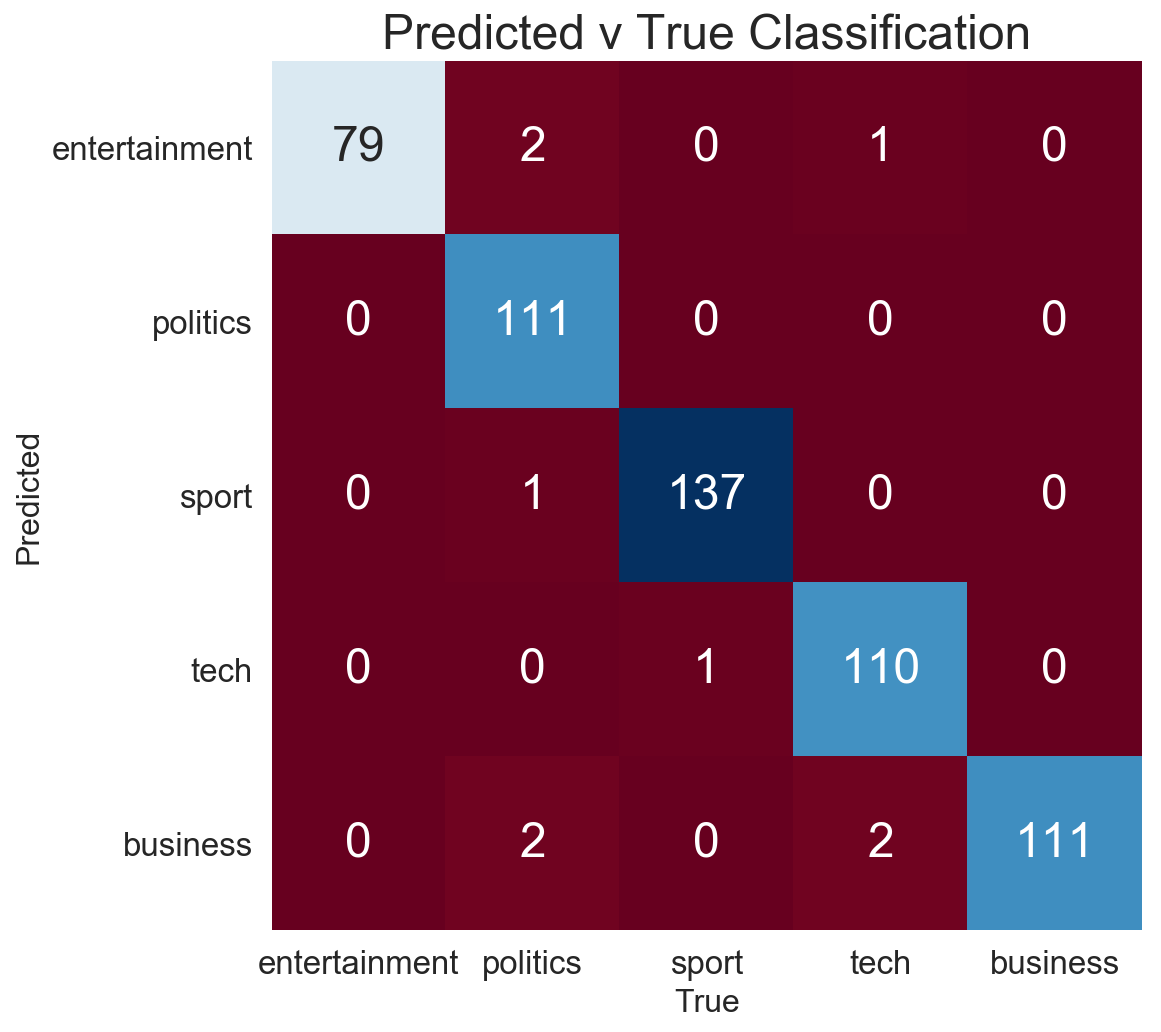

In [19]:
cm = confusion_matrix(list(y_test), predictions)
plt.figure(figsize=(14,8))
sns.heatmap(cm, square=True, annot=True, annot_kws={"fontsize":24}, cmap='RdBu', cbar=False,
xticklabels=path_list, yticklabels=path_list,fmt='d')
plt.title('Predicted v True Classification',fontsize=24)
_ = plt.xlabel('True',fontsize=16)
_ = plt.ylabel('Predicted',fontsize=16)

The Naive Bayes classification method works particularly well for this data set, as seen by the high accuracy score. We see it in the heatmap as well that most of the documents in the test data were classified correctly. The true test would be if we could get a newer dataset of bbc news documents and run them in our algorithm.

# Youtube Link